In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Pre-reading material:**

PyTorch (Hello World):
1. https://nestedsoftware.com/2019/08/15/pytorch-hello-world-37mo.156165.html

Generative Adversarial Networks:

1. https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29
1. https://towardsdatascience.com/the-math-behind-gans-generative-adversarial-networks-3828f3469d9c
1. https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/
1. https://srome.github.io/An-Annotated-Proof-of-Generative-Adversarial-Networks-with-Implementation-Notes/
1. https://developers.google.com/machine-learning/gan/loss

SPADE GAN:

1. https://blog.paperspace.com/nvidia-gaugan-introduction/
1. https://medium.com/@kushajreal/spade-state-of-the-art-in-image-to-image-translation-by-nvidia-bb49f2db2ce3
1. https://arxiv.org/pdf/1903.07291.pdf

Spectral Normalization:
1. https://christiancosgrove.com/blog/2018/01/04/spectral-normalization-explained.html

Synchronized batch normalization:
https://github.com/vacancy/Synchronized-BatchNorm-PyTorch

https://github.com/NVlabs/SPADE/blob/master/README.md#installation


In [0]:
%%bash
mkdir -p extlib
cd extlib/

git clone https://github.com/vacancy/Synchronized-BatchNorm-PyTorch
cp -rf Synchronized-BatchNorm-PyTorch/sync_batchnorm .


Cloning into 'Synchronized-BatchNorm-PyTorch'...


**SPADE Normalizer Module:**

In [0]:
from PIL import Image
def showImage(path, width):
  img = Image.open(path)
  wpercent = (width/float(img.size[0]))
  height = int((float(img.size[1])*float(wpercent)))
  return img.resize((width,height), Image.ANTIALIAS)

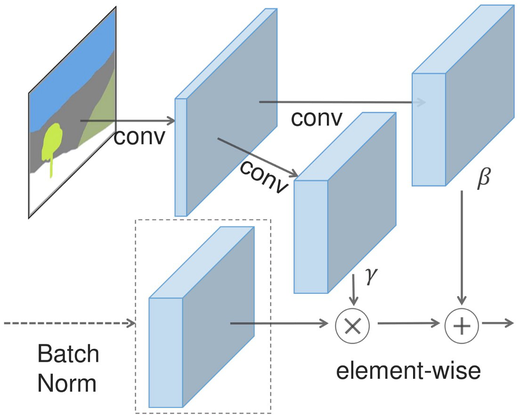

In [36]:
showImage('/content/gdrive/My Drive/development/ai/3-gaugan/readme/spade_norm_2.jpeg', 520)

In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from extlib.sync_batchnorm import SynchronizedBatchNorm2d

# norm_nc: the #channels of the normalized activations, hence the output dim of SPADE
# label_nc: the #channels of the input semantic map, hence the input dim of SPADE
# label_nc: also equivalent to the # of input label classes
class SPADE(nn.Module):
  def __init__(self, norm_nc, label_nc):
    super().__init__()

    self.param_free_norm = SynchronizedBatchNorm2d(norm_nc, affine=False)

    # number of internal filters for generating scale/bias
    nhidden = 128
    # size of kernels
    kernal_size = 3
    # padding size
    padding = kernal_size // 2

    self.mlp_shared = nn.Sequential(
      nn.Conv2d(label_nc, nhidden, kernel_size=kernal_size, padding=padding),
      nn.ReLU()
    )
    self.mlp_gamma = nn.Conv2d(nhidden, norm_nc, kernel_size=kernal_size, padding=padding)
    self.mlp_beta = nn.Conv2d(nhidden, norm_nc, kernel_size=kernal_size, padding=padding)

  def forward(self, x, segmap):
    # Part 1. generate parameter-free normalized activations
    normalized = self.param_free_norm(x)

    # Part 2. produce scaling and bias conditioned on semantic map
    # resize input segmentation map to match x.size() using nearest interpolation
    # N, C, H, W = x.size()
    segmap = F.interpolate(segmap, size=x.size()[2:], mode='nearest')
    actv = self.mlp_shared(segmap)
    gamma = self.mlp_gamma(actv)
    beta = self.mlp_beta(actv)

    # apply scale and bias
    out = normalized * (1 + gamma) + beta

    return out


**SPADE ResnetBlock:**

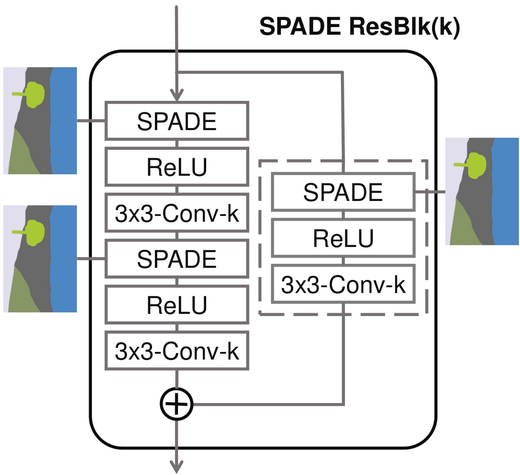

In [39]:
showImage('/content/gdrive/My Drive/development/ai/3-gaugan/readme/spade_resblk.jpeg', 520)

In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

import torch.nn.utils.spectral_norm as spectral_norm

# label_nc: the #channels of the input semantic map, hence the input dim of SPADE
# label_nc: also equivalent to the # of input label classes
class SPADEResnetBlock(nn.Module):
  def __init__(self, opt, fin, fout):
    super().__init__()

    self.learned_shortcut = (fin != fout)
    fmiddle = min(fin, fout)

    self.conv_0 = nn.Conv2d(fin, fmiddle, kernel_size=3, padding=1)
    self.conv_0 = spectral_norm(self.conv_0)
    self.conv_1 = spectral_norm(nn.Conv2d(fmiddle, fout, kernel_size=3, padding=1))
    if self.learned_shortcut:
      self.conv_s = spectral_norm(nn.Conv2d(fin, fout, kernel_size=1, bias=False))

    # define normalization layers
    self.norm_0 = SPADE(fin, opt['semantic_nc'])
    self.norm_1 = SPADE(fmiddle, opt['semantic_nc'])
    if self.learned_shortcut:
      self.norm_s = SPADE(fin, opt['semantic_nc'])

  # note the resnet block with SPADE also takes in |seg|,
  # the semantic segmentation map as input
  def forward(self, x, seg):
    x_s = self.shortcut(x, seg)

    dx = self.conv_0(self.relu(self.norm_0(x, seg)))
    dx = self.conv_1(self.relu(self.norm_1(dx, seg)))

    out = x_s + dx
    return out

  def shortcut(self, x, seg):
    if self.learned_shortcut:
      x_s = self.conv_s(self.norm_s(x, seg))
    else:
      x_s = x
    return x_s

  def relu(self, x):
    return F.leaky_relu(x, 2e-1)


**SPADE Generator:**

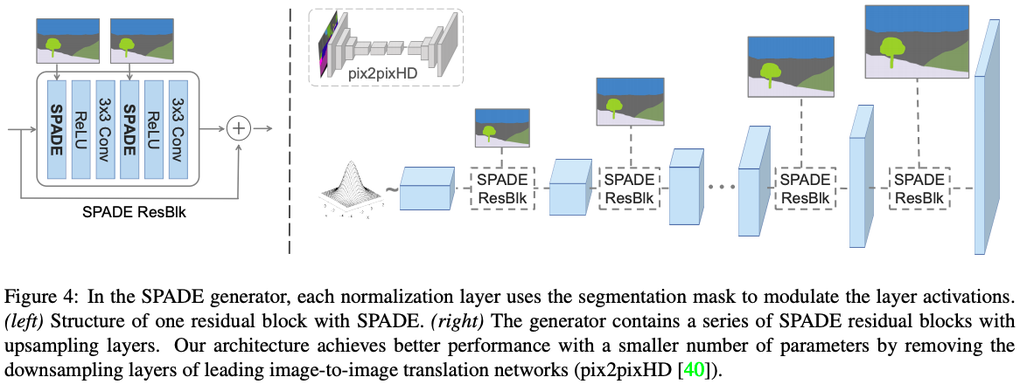

In [41]:
showImage('/content/gdrive/My Drive/development/ai/3-gaugan/readme/spade_generator.png', 1020)

In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

class SPADEGenerator(nn.Module):
  def __init__(self, opt):
    super().__init__()

    # nf: # of gen filters in first conv layer
    nf = 64

    self.sw, self.sh = self.compute_latent_vector_size(opt['crop_size'], opt['aspect_ratio'])

    self.fc = nn.Conv2d(opt['semantic_nc'], 16 * nf, 3, padding=1)

    self.head_0 = SPADEResnetBlock(opt, 16 * nf, 16 * nf)

    self.G_middle_0 = SPADEResnetBlock(opt, 16 * nf, 16 * nf)
    self.G_middle_1 = SPADEResnetBlock(opt, 16 * nf, 16 * nf)

    self.up_0 = SPADEResnetBlock(opt, 16 * nf, 8 * nf)
    self.up_1 = SPADEResnetBlock(opt, 8 * nf, 4 * nf)
    self.up_2 = SPADEResnetBlock(opt, 4 * nf, 2 * nf)
    self.up_3 = SPADEResnetBlock(opt, 2 * nf, 1 * nf)

    self.conv_img = nn.Conv2d(1 * nf, 3, 3, padding=1)

    self.up = nn.Upsample(scale_factor=2)
  
  def compute_latent_vector_size(self, crop_size, aspect_ratio):
    num_up_layers = 5

    sw = crop_size // (2**num_up_layers)
    sh = round(sw / aspect_ratio)

    return sw, sh
  
  def forward(self, seg):
    # we downsample segmap and run convolution
    x = F.interpolate(seg, size=(self.sh, self.sw))
    x = self.fc(x)

    x = self.head_0(x, seg)

    x = self.up(x)
    x = self.G_middle_0(x, seg)
    x = self.G_middle_1(x, seg)

    x = self.up(x)
    x = self.up_0(x, seg)
    x = self.up(x)
    x = self.up_1(x, seg)
    x = self.up(x)
    x = self.up_2(x, seg)
    x = self.up(x)
    x = self.up_3(x, seg)

    x = self.conv_img(F.leaky_relu(x, 2e-1))
    x = torch.tanh(x)

    return x
    


In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

import os
from torch.nn import init

class Pix2PixModel(torch.nn.Module):
  def __init__(self, opt):
    super().__init__()
    self.opt = opt
    self.FloatTensor = torch.cuda.FloatTensor if opt['use_gpu'] \
      else torch.FloatTensor

    self.netG = self.initialize_generator(opt)
  
  def forward(self, data, mode):
    if mode == 'inference':
      input_semantics, real_image = self.preprocess_input(data)
      
      with torch.no_grad():
        fake_image = self.generate_fake(input_semantics)
      return fake_image
    else:
      raise ValueError("|mode| is invalid")
  
  def preprocess_input(self, data):
    data['label'] = data['label'].long()

    # move to GPU and change data types
    if self.opt['use_gpu']:
      data['label'] = data['label'].cuda()
      data['instance'] = data['instance'].cuda()
      data['image'] = data['image'].cuda()

    # create one-hot label map
    label_map = data['label']
    bs, _, h, w = label_map.size()
    nc = self.opt['label_nc']+ 1 if self.opt['contain_dontcare_label'] \
      else self.opt['label_nc']
    input_label = self.FloatTensor(bs, nc, h, w).zero_()
    # one whole label map -> to one label map per class
    input_semantics = input_label.scatter_(1, label_map, 1.0)

    return input_semantics, data['image']
  
  def generate_fake(self, input_semantics):
    fake_image = self.netG(input_semantics)
    return fake_image
  
  def create_network(self, cls, opt):
    net = cls(opt)
    if self.opt['use_gpu']:
      net.cuda()

    gain=0.02
    def init_weights(m):
      classname = m.__class__.__name__
      if classname.find('BatchNorm2d') != -1:
        if hasattr(m, 'weight') and m.weight is not None:
          init.normal_(m.weight.data, 1.0, gain)
        if hasattr(m, 'bias') and m.bias is not None:
          init.constant_(m.bias.data, 0.0)
      elif hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.xavier_normal_(m.weight.data, gain=gain)
        if hasattr(m, 'bias') and m.bias is not None:
          init.constant_(m.bias.data, 0.0)
    # Applies fn recursively to every submodule (as returned by .children()) as well as self
    net.apply(init_weights)
    
    return net
  
  def load_network(self, net, label, epoch, opt):
    save_filename = '%s_net_%s.pth' % (epoch, label)
    save_path = os.path.join(opt['checkpoints_dir'], save_filename)
    weights = torch.load(save_path)
    net.load_state_dict(weights)
    return net

  def initialize_generator(self, opt):
    netG = self.create_network(SPADEGenerator, opt)

    if not opt['isTrain'] or opt['continue_train']:
      netG = self.load_network(netG, 'G', opt['which_epoch'], opt)
    
    # self.print_network(netG)

    return netG
  
  def print_network(self, net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print('Network [%s] was created. Total number of parameters: %.1f million. '
          % (type(net).__name__, num_params / 1000000))
    print(net)
  

In [0]:
def set_options(opt):
  # Set semantic_nc based on the option.
  # This will be convenient in many places
  opt['semantic_nc'] = opt['label_nc'] + \
      (1 if opt['contain_dontcare_label'] else 0)

In [0]:
opt = {
  'label_nc': 182, # num classes in coco model
  'contain_dontcare_label': False,
  'crop_size': 512,
  'load_size': 512,
  'aspect_ratio': 1.0,
  'preprocess_mode': 'scale_width',
  'isTrain': False,
  'checkpoints_dir': '/content/gdrive/My Drive/development/ai/3-gaugan/pretrained',
  'which_epoch': 'latest',
  'use_gpu': True
}
set_options(opt)

model = Pix2PixModel(opt)
for layer in model.netG.children():
  print(layer)
del model

Conv2d(182, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
SPADEResnetBlock(
  (conv_0): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_0): SPADE(
    (param_free_norm): SynchronizedBatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (mlp_shared): Sequential(
      (0): Conv2d(182, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (mlp_gamma): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (mlp_beta): Conv2d(128, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (norm_1): SPADE(
    (param_free_norm): SynchronizedBatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (mlp_shared): Sequential(
      (0): Conv2d(182, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (mlp_gamma): Conv2d(128, 1024,

**Testing the Generator using Pre-trained Model:**

From the whitepaper (https://arxiv.org/pdf/1903.07291.pdf) and (https://github.com/abraham-ai/eden/blob/master/examples/spade.ipynb): 

Flickr images were taken and segmented using the *deeplabv2_resnet101_msc-cocostuff164k-100000.pth* model:
https://github.com/kazuto1011/deeplab-pytorch


In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

import torchvision.transforms as transforms
from PIL import Image

import random

def __scale_width(img, target_width, method=Image.BICUBIC):
  ow, oh = img.size
  if (ow == target_width):
    return img
  w = target_width
  h = int(target_width * oh / ow)
  return img.resize((w, h), method)

def __crop(img, pos, size):
  ow, oh = img.size
  x1, y1 = pos
  tw = th = size
  return img.crop((x1, y1, x1 + tw, y1 + th))

def get_params(opt, size):
  w, h = size
  new_h = h
  new_w = w
  if opt['preprocess_mode'] == 'resize_and_crop':
    new_h = new_w = opt['load_size']
  
  x = random.randint(0, np.maximum(0, new_w - opt['crop_size']))
  y = random.randint(0, np.maximum(0, new_h - opt['crop_size']))

  return {'crop_pos': (x, y)}

def get_transform(opt, params, method=Image.BICUBIC, normalize=True):
  transform_list = []
  if 'resize' in opt['preprocess_mode']:
    osize = [opt['load_size'], opt['load_size']]
    transform_list.append(transforms.Resize(osize, interpolation=method))
  elif 'scale_width' in opt['preprocess_mode']:
    transform_list.append(transforms.Lambda(lambda img: __scale_width(img, opt['load_size'], method)))
  
  if 'crop' in opt['preprocess_mode']:
    transform_list.append(transforms.Lambda(lambda img: __crop(img, params['crop_pos'], opt['crop_size'])))
  
  transform_list += [transforms.ToTensor()]
  if normalize:
    transform_list += [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
  
  return transforms.Compose(transform_list)

def get_dataset_input(opt, label_image, image):
  params = get_params(opt, label_image.size)
  transform_label = get_transform(opt, params, method=Image.NEAREST, normalize=False)
  # transforms.ToTensor in transform_label rescales image from [0,255] to [0.0,1.0]
  # lets rescale it back to [0,255] to match our label ids
  label_tensor = transform_label(label_image) * 255.0
  label_tensor[label_tensor == 255] = opt['label_nc'] # 'unknown' is opt.label_nc

  transform_image = get_transform(opt, params)
  image_tensor = transform_image(image)

  instance_tensor = 0

  input_dict = {'label': label_tensor,
    'instance': instance_tensor,
    'image': image_tensor,
    }
  
  return input_dict

In [0]:
%%bash

cd extlib/
rm -rf deeplab-pytorch deeplab_pytorch
git clone https://github.com/kazuto1011/deeplab-pytorch.git

mv deeplab-pytorch deeplab_pytorch

Cloning into 'deeplab-pytorch'...


In [0]:
%%bash
pip3 install addict
pip3 install pydensecrf

  Created wheel for pydensecrf: filename=pydensecrf-1.0rc3-cp36-cp36m-linux_x86_64.whl size=2153647 sha256=74fc0fabab78e57caeecdfd057809e19758df587599ce947a6ba28522d77c451
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


In [0]:
import sys
sys.path.insert(0, '/content/extlib/deeplab_pytorch/')

In [0]:
# https://github.com/kazuto1011/deeplab-pytorch/blob/master/demo.py
# load a image and generate image segmentation mappings

import cv2
import numpy as np
import yaml
from addict import Dict
from demo import get_device, get_classtable, setup_postprocessor, preprocessing, inference
from libs.models import *

def deeplab_setup(cuda=True):
  config_path = '/content/extlib/deeplab_pytorch/configs/cocostuff164k.yaml'
  model_path = '/content/gdrive/My Drive/development/ai/3-gaugan/deeplab-pytorch/deeplabv2_resnet101_msc-cocostuff164k-100000.pth'
  crf = True

  CONFIG = Dict(yaml.load(open(config_path, 'rb')))
  device = get_device(cuda)

  CONFIG.DATASET.LABELS = "/content/extlib/deeplab_pytorch/data/datasets/cocostuff/labels.txt"
  classes = get_classtable(CONFIG)
  postprocessor = setup_postprocessor(CONFIG) if crf else None

  model = eval(CONFIG.MODEL.NAME)(n_classes=CONFIG.DATASET.N_CLASSES)
  state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
  model.load_state_dict(state_dict)
  model.eval()
  model.to(device)

  ctx = {}
  ctx['CONFIG'] = CONFIG
  ctx['model'] = model
  ctx['device'] = device
  ctx['postprocessor'] = postprocessor
  return ctx

def gen_labels(ctx, image_path):
  image = cv2.imread(image_path, cv2.IMREAD_COLOR)
  print("image shape:", image.shape)

  image, raw_image = preprocessing(image, ctx['device'], ctx['CONFIG'])
  labelmap = inference(ctx['model'], image, raw_image, ctx['postprocessor'])
  return labelmap

torch.set_grad_enabled(False)
ctx = deeplab_setup()
labelmap = gen_labels(ctx, "/content/gdrive/My Drive/development/ai/3-gaugan/dataset/images/mountains.jpg")
del ctx
torch.set_grad_enabled(True)

print("labelmap:", labelmap)
print("labelmap shape:", labelmap.shape)

np.save('labelmap', labelmap)



Device: Tesla P100-PCIE-16GB
image shape: (512, 512, 3)
labelmap: [[105 105 105 ... 134 134 134]
 [105 105 105 ... 134 134 134]
 [105 105 105 ... 134 134 134]
 ...
 [123 123 123 ... 123 123 123]
 [123 123 123 ... 123 123 123]
 [123 123 123 ... 123 123 123]]
labelmap shape: (513, 513)


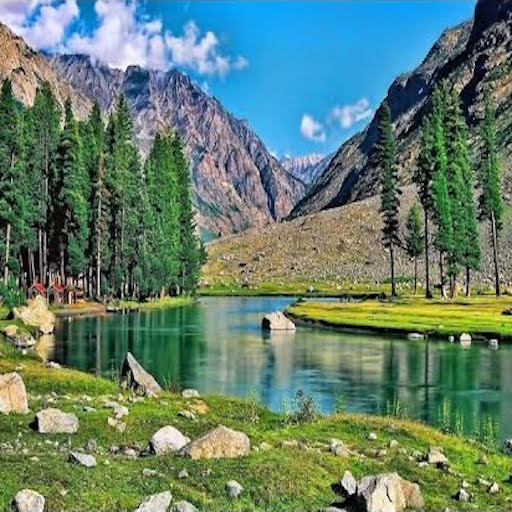

In [0]:
from matplotlib import pyplot as plt
from PIL import Image

Image.open('/content/gdrive/My Drive/development/ai/3-gaugan/dataset/images/mountains.jpg')

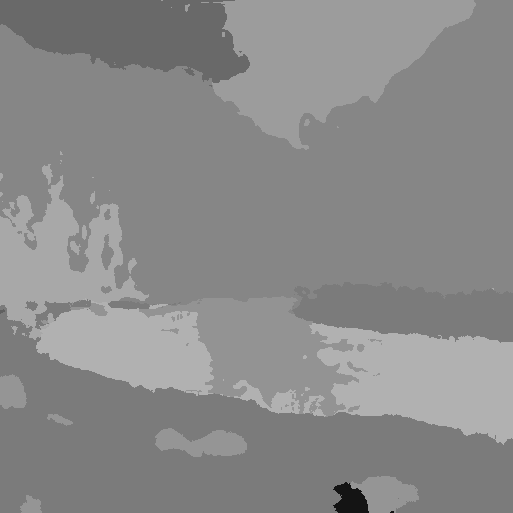

In [0]:
# plt.imshow(np.stack((labelmap,)*3, axis=-1))
Image.fromarray(np.array(labelmap).astype(np.uint8))

In [0]:
def evaluate(labelmap):
  opt = {
    'label_nc': 182, # num classes in coco model
    'contain_dontcare_label': False,
    'crop_size': 512,
    'load_size': 512,
    'aspect_ratio': 1.0,
    'preprocess_mode': 'scale_width',
    'isTrain': False,
    'checkpoints_dir': '/content/gdrive/My Drive/development/ai/3-gaugan/pretrained',
    'which_epoch': 'latest',
    'use_gpu': True
  }
  set_options(opt)

  model = Pix2PixModel(opt)
  model.eval()

  label_image = Image.fromarray(np.array(labelmap).astype(np.uint8))
  # not using encoder, so creating a blank image...
  image = Image.new('RGB', (500, 500))

  dataset = get_dataset_input(opt, label_image, image)
  print("label_tensor:", dataset['label'].shape)

  data = {
    # unsqueeze(0) adds the batch size of 1 in first dim position
    'label': dataset['label'].unsqueeze(0),
    'instance': dataset['label'].unsqueeze(0),
    'image': dataset['image'].unsqueeze(0)
  }
  generated = model(data, mode='inference')
  print("generated_image:", generated.shape)

  return generated

generated = evaluate(labelmap)
del labelmap

label_tensor: torch.Size([1, 512, 512])
generated_image: torch.Size([1, 3, 512, 512])


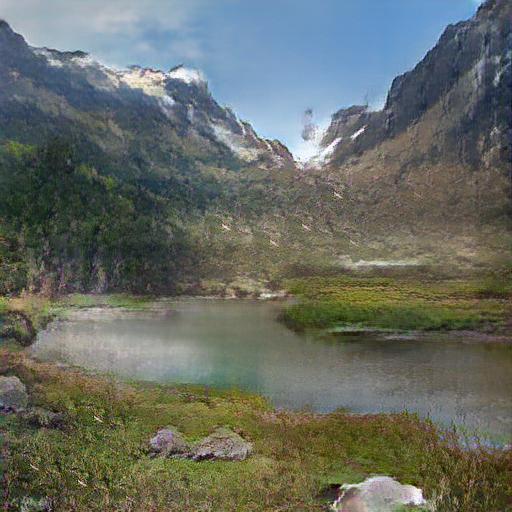

In [0]:
from torchvision.transforms import ToPILImage
from IPython.display import display

def to_image(generated, h, w):
  to_img = ToPILImage()
  normalized_img = ((generated.reshape([3, h, w]) + 1) / 2.0) * 255.0
  return to_img(normalized_img.byte().cpu())

display(to_image(generated, 512, 512))
del generated

**Discriminator:**

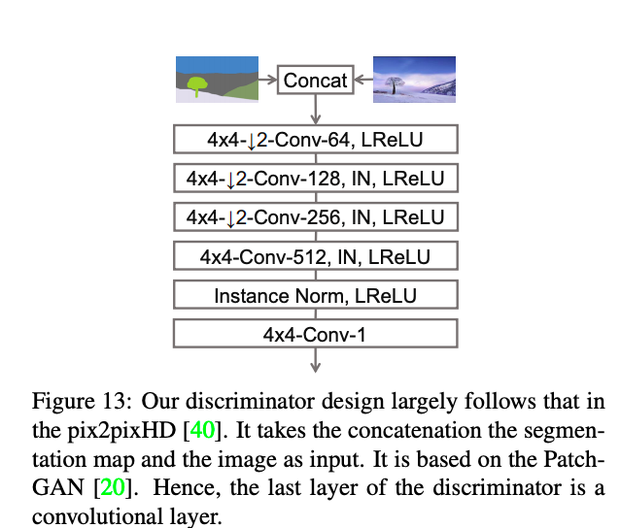

In [43]:
showImage('/content/gdrive/My Drive/development/ai/3-gaugan/readme/spade_discriminator.png', 620)

In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

import numpy as np
import torch.nn.utils.spectral_norm as spectral_norm

def get_nonspade_norm_layer(opt):
  # helper function to get # output channels of the previous layer
  def get_out_channel(layer):
    if hasattr(layer, 'out_channels'):
      return getattr(layer, 'out_channels')
    return layer.weight.size(0)
  
  def add_norm_layer(layer):
    layer = spectral_norm(layer)

    # remove bias in the previous layer, which is meaningless
    # since it has no effect after normalization
    # this is due to normalization again in next step
    if getattr(layer, 'bias', None) is not None:
      delattr(layer, 'bias')
      layer.register_parameter('bias', None)
    
    norm_layer = nn.InstanceNorm2d(get_out_channel(layer), affine=False)

    return nn.Sequential(layer, norm_layer)
  
  return add_norm_layer


class NLayerDiscriminator(nn.Module):
  def __init__(self, opt):
    super().__init__()
    self.opt = opt

    # layers in each discriminator
    self.n_layers_D = 4

    kw = 4
    padw = int(np.ceil((kw - 1.0) / 2))
    # number of discrim filters in first conv layer
    # nf = opt.ndf
    nf = 64
    input_nc = self.compute_D_input_nc(opt)

    sequence = [[nn.Conv2d(input_nc, nf, kernel_size=kw, stride=2, padding=padw),
      nn.LeakyReLU(0.2, False)]]
    
    norm_layer = get_nonspade_norm_layer(opt)
    for n in range(1, self.n_layers_D):
      nf_prev = nf
      nf = min(nf * 2, 512)
      stride = 1 if n == self.n_layers_D - 1 else 2
      sequence += [[norm_layer(nn.Conv2d(nf_prev, nf, kernel_size=kw,
            stride=stride, padding=padw)),
          nn.LeakyReLU(0.2, False)
        ]]
    
    sequence += [[nn.Conv2d(nf, 1, kernel_size=kw, stride=1, padding=padw)]]

    # We divide the layers into groups to extract intermediate layer outputs
    for n in range(len(sequence)):
      # print(sequence[n])
      self.add_module('model' + str(n), nn.Sequential(*sequence[n]))
      # similar to:
      # self.model1 = nn.Sequential(*sequence[n])
  
  def compute_D_input_nc(self, opt):
    output_nc = 3 # rgb
    # segmentation layer + generated image (3)
    input_nc = opt['label_nc'] + output_nc
    if opt['contain_dontcare_label']:
      input_nc += 1
    return input_nc
  
  def forward(self, input):
    results = [input]
    for submodel in self.children():
      intermediate_output = submodel(results[-1])
      results.append(intermediate_output)
    
    get_intermediate_features = False
    if get_intermediate_features:
      return results[1:]
    else:
      return results[-1]

In [0]:
opt = {
  'label_nc': 182, # num classes in coco model
  'contain_dontcare_label': False,
  'crop_size': 512,
  'load_size': 512,
  'aspect_ratio': 1.0,
  'preprocess_mode': 'scale_width',
  'isTrain': False,
  'checkpoints_dir': '/content/gdrive/My Drive/development/ai/3-gaugan/pretrained',
  'which_epoch': 'latest',
  'use_gpu': True
}
set_options(opt)

model = NLayerDiscriminator(opt)
for name, layer in model.named_children():
  print('children()', name, layer)
for name, layer in model.named_modules():
  print('modules()', name, layer)
del model

children() model0 Sequential(
  (0): Conv2d(185, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (1): LeakyReLU(negative_slope=0.2)
)
children() model1 Sequential(
  (0): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (1): LeakyReLU(negative_slope=0.2)
)
children() model2 Sequential(
  (0): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (1): LeakyReLU(negative_slope=0.2)
)
children() model3 Sequential(
  (0): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2), bias=False)
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  )
  (1): LeakyReLU(negative_slope=0.2)
)
children() model4 Sequential(


In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

class MultiscaleDiscriminator(nn.Module):
  def __init__(self, opt):
    super().__init__()
    self.opt = opt

    for i in range(opt['num_D']):
      subnetD = NLayerDiscriminator(opt)
      self.add_module('discriminator_%d' % i, subnetD)
  
  def downsample(self, input):
    return F.avg_pool2d(input, kernel_size=3,
      stride=2, padding=[1, 1],
      count_include_pad=False)
  
  # Returns list of lists of discriminator outputs.
  # The final result is of size opt.num_D x opt.n_layers_D
  def forward(self, input):
    result = []
    get_intermediate_features = False
    for name, D in self.named_children():
      out = D(input)
      if not get_intermediate_features:
        out = [out]
      result.append(out)
      input = self.downsample(input)

    return result

In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

class Pix2PixModel(Pix2PixModel):
  def __init__(self, opt):
    super().__init__(opt)

    self.netD = self.initialize_discriminator(opt)

    # set loss functions
    if opt['isTrain']:
      self.criterionGAN = GANLoss(tensor=self.FloatTensor)

  def forward(self, data, mode):
    if mode == 'discriminator':
      input_semantics, real_image = self.preprocess_input(data)

      d_loss = self.compute_discriminator_loss(
        input_semantics, real_image)
      return d_loss
    
    return super().forward(data, mode)
  
  def initialize_discriminator(self, opt):
    netD = self.create_network(MultiscaleDiscriminator, opt) if opt['isTrain'] else None

    if opt['isTrain'] and opt['continue_train']:
      netD = self.load_network(netD, 'D', opt['which_epoch'], opt)

    return netD

  def compute_discriminator_loss(self, input_semantics, real_image):
    D_losses = {}
    with torch.no_grad():
      fake_image = self.generate_fake(input_semantics)
      # detach here from generator, so as to not update the parameters for it
      fake_image = fake_image.detach()
      # require loss from here on, since we call discriminator next!
      fake_image.requires_grad_()
    
    pred_fake, pred_real = self.discriminate(
      input_semantics, fake_image, real_image)
    
    D_losses['D_Fake'] = self.criterionGAN(pred_fake, False,
      for_discriminator=True)
    D_losses['D_real'] = self.criterionGAN(pred_real, True,
      for_discriminator=True)

    return D_losses
  
  # Given fake and real image, return the prediction of discriminator
  # for each fake and real image.
  def discriminate(self, input_semantics, fake_image, real_image):
    fake_concat = torch.cat([input_semantics, fake_image], dim=1)
    real_concat = torch.cat([input_semantics, real_image], dim=1)

    # In Batch Normalization, the fake and real images are
    # recommended to be in the same batch to avoid disparate
    # statistics in fake and real images.
    # So both fake and real images are fed to D all at once.
    fake_and_real = torch.cat([fake_concat, real_concat], dim=0)

    discriminator_out = self.netD(fake_and_real)

    pred_fake, pred_real = self.divide_pred(discriminator_out)

    return pred_fake, pred_real
  
  # Take the prediction of fake and real images from the combined batch
  def divide_pred(self, pred):
    # the prediction contains the intermediate outputs of multiscale GAN,
    # so it's usually a list
    if type(pred) == list:
      fake = []
      real = []
      for p in pred:
        fake.append([tensor[:tensor.size(0) // 2] for tensor in p])
        real.append([tensor[tensor.size(0) // 2:] for tensor in p])
    else:
      fake = pred[:pred.size(0) // 2]
      real = pred[pred.size(0) // 2:]

    return fake, real


**GAN - Discriminator Hinge Loss:**

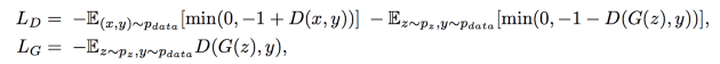

In [44]:
showImage('/content/gdrive/My Drive/development/ai/3-gaugan/readme/spade_loss.png', 720)

In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

class GANLoss(nn.Module):
  def __init__(self, tensor=torch.FloatTensor):
    super().__init__()

    self.zero_tensor = None
    self.Tensor = tensor
    
  def loss(self, input, target_is_real, for_discriminator=True):
    if for_discriminator:
      if target_is_real:
        minval = torch.min(input - 1, self.get_zero_tensor(input))
        # multiply by -1 to reverse. inverse of gradient descent is maximizing!
        loss = -torch.mean(minval)
      else:
        minval = torch.min(-input - 1, self.get_zero_tensor(input))
        loss = -torch.mean(minval)
    else:
      assert target_is_real, "The generator's hinge loss must be aiming for real"
      # input = output from discriminator. 0 if false and 1 if true 
      # out generator is targetting values of 1, since we want to produce "real" images
      # multiply by -1 to maximize out input!
      loss = -torch.mean(input)
    return loss

  # entry point from model
  def __call__(self, input, target_is_real, for_discriminator=True):
    # computing loss is a bit complicated because |input| may not be
    # a tensor, but list of tensors in case of multiscale discriminator
    if isinstance(input, list):
      loss = 0
      for pred_i in input:
        if isinstance(pred_i, list):
          pred_i = pred_i[-1]
        loss_tensor = self.loss(pred_i, target_is_real, for_discriminator)
        bs = 1 if len(loss_tensor.size()) == 0 else loss_tensor.size(0)
        new_loss = torch.mean(loss_tensor.view(bs, -1), dim=1)
        loss += new_loss
      return loss / len(input)
    else:
      return self.loss(input, target_is_real, for_discriminator)
  
  def get_zero_tensor(self, input):
    if self.zero_tensor is None:
      self.zero_tensor = self.Tensor(1).fill_(0)
      self.zero_tensor.requires_grad_(False)
    return self.zero_tensor.expand_as(input)


In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

class Pix2PixModel(Pix2PixModel):
  def __init__(self, opt):
    super().__init__(opt)

    # distance sum(|y_true - y_predicted|)
    # https://afteracademy.com/blog/what-are-l1-and-l2-loss-functions
    self.criterionFeat = torch.nn.L1Loss()
    if not opt['no_vgg_loss']:
      self.criterionVGG = VGGLoss()
  
  def forward(self, data, mode):
    if mode == 'generator':
      input_semantics, real_image = self.preprocess_input(data)
      
      g_loss, generated = self.compute_generator_loss(
        input_semantics, real_image)
      return g_loss, generated
    
    return super().forward(data, mode)
  
  def compute_generator_loss(self, input_semantics, real_image):
    G_losses = {}

    fake_image = self.generate_fake(input_semantics)

    # get discriminator loss
    pred_fake, pred_real = self.discriminate(
      input_semantics, fake_image, real_image)
    
    G_losses['GAN'] = self.criterionGAN(pred_fake, True,
      for_discriminator=False)
    
    if not self.opt['no_ganFeat_loss']:
      num_D = len(pred_fake)
      GAN_Feat_loss = self.FloatTensor(1).fill_(0)
      for i in range(num_D):  # for each discriminator
        # last output is the final prediction, so we exclude it
        num_intermediate_outputs = len(pred_fake[i]) - 1
        for j in range(num_intermediate_outputs):  # for each layer output
          unweighted_loss = self.criterionFeat(
            pred_fake[i][j], pred_real[i][j].detach())
          GAN_Feat_loss += unweighted_loss * self.opt['lambda_feat'] / num_D
      G_losses['GAN_Feat'] = GAN_Feat_loss
    
    if not self.opt['no_vgg_loss']:
      G_losses['VGG'] = self.criterionVGG(fake_image, real_image) \
        * self.opt['lambda_vgg']

    return G_losses, fake_image
  
  def create_optimizers(self, opt):
    G_params = list(self.netG.parameters())
    if opt['isTrain']:
      D_params = list(self.netD.parameters())

    beta1, beta2 = opt['beta1'], opt['beta2']
    G_lr, D_lr = opt['lr'] / 2, opt['lr'] * 2

    optimizer_G = torch.optim.Adam(G_params, lr=G_lr, betas=(beta1, beta2))
    optimizer_D = torch.optim.Adam(D_params, lr=D_lr, betas=(beta1, beta2))

    return optimizer_G, optimizer_D
  
  def save(self, epoch):
    self.save_network(self.netG, 'G', epoch, self.opt)
    self.save_network(self.netD, 'D', epoch, self.opt)
  
  def save_network(self, net, label, epoch, opt):
    save_filename = '%s_net_%s.pth' % (epoch, label)
    save_path = os.path.join(opt['checkpoints_dir'], save_filename)
    torch.save(net.cpu().state_dict(), save_path)
    if opt['use_gpu']:
      net.cuda()

**GAN - Generator Loss:**

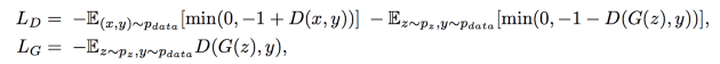

In [45]:
showImage('/content/gdrive/My Drive/development/ai/3-gaugan/readme/spade_loss.png', 720)

In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

class GANLoss(GANLoss):
  def __init__(self, tensor=torch.FloatTensor):
    super().__init__(tensor)
    
  def loss(self, input, target_is_real, for_discriminator=True):
    if not for_discriminator:
      assert target_is_real, "The generator's hinge loss must be aiming for real"
      # input = output from discriminator. 0 if false and 1 if true 
      # out generator is targetting values of 1, since we want to produce "real" images
      # multiply by -1 to maximize out input!
      loss = -torch.mean(input)
      return loss
    return super().loss(input, target_is_real, for_discriminator)


**Feature Matching Loss**

$L_{FM} (G,D_k) =  \mathop{\mathbb{E}} {}_{s,x} \:\sum_{i=1}^{T}  \frac{1}{N_{i}}[||D^{(i)}_{k}{(s,x)} - D^{(i)}_{k}{(s,G(s))}||_1]$

Here $k$ represents which image scale we are using. We use $T$ feature maps from the discriminator and $N_i$ is the normalizing constant for each feature map so that the L1 difference between every pair of feature maps has the same scale despite different number of filters in each feature map.

**VGG Loss**

This loss is similar to the above loss, the only difference being instead of using the discriminator to compute the feature maps, we use a VGG-19 pre-trained on Imagenet to compute the feature maps for real and the fake images. We then penalise the the L1 distance between these maps.

$L_{VGG} (G,D_k) = \mathop{\mathbb{E}}_{s,x} \:\sum_{i=1}^{5}  \frac{1}{2^i}[||VGG{(x,M_{i})} - VGG(G(s), M_i)||_1]$

In [0]:
import torchvision

# Perceptual loss that uses a pretrained VGG network
class VGGLoss(nn.Module):
  def __init__(self):
    super(VGGLoss, self).__init__()
    self.vgg = VGG19().cuda()
    self.criterion = nn.L1Loss()
    self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]

  def forward(self, x, y):
    x_vgg, y_vgg = self.vgg(x), self.vgg(y)
    loss = 0
    for i in range(len(x_vgg)):
      loss += self.weights[i] * self.criterion(x_vgg[i], y_vgg[i].detach())
    return loss

# VGG architecter, used for the perceptual loss using a pretrained VGG network
class VGG19(torch.nn.Module):
  def __init__(self, requires_grad=False):
    super().__init__()
    vgg_pretrained_features = torchvision.models.vgg19(pretrained=True).features
    self.slice1 = torch.nn.Sequential()
    self.slice2 = torch.nn.Sequential()
    self.slice3 = torch.nn.Sequential()
    self.slice4 = torch.nn.Sequential()
    self.slice5 = torch.nn.Sequential()
    for x in range(2):
      self.slice1.add_module(str(x), vgg_pretrained_features[x])
    for x in range(2, 7):
      self.slice2.add_module(str(x), vgg_pretrained_features[x])
    for x in range(7, 12):
      self.slice3.add_module(str(x), vgg_pretrained_features[x])
    for x in range(12, 21):
      self.slice4.add_module(str(x), vgg_pretrained_features[x])
    for x in range(21, 30):
      self.slice5.add_module(str(x), vgg_pretrained_features[x])
    if not requires_grad:
      for param in self.parameters():
        param.requires_grad = False

  def forward(self, X):
    h_relu1 = self.slice1(X)
    h_relu2 = self.slice2(h_relu1)
    h_relu3 = self.slice3(h_relu2)
    h_relu4 = self.slice4(h_relu3)
    h_relu5 = self.slice5(h_relu4)
    out = [h_relu1, h_relu2, h_relu3, h_relu4, h_relu5]
    return out

In [0]:
"""
Copyright (C) 2019 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""

from extlib.sync_batchnorm import DataParallelWithCallback

class Pix2PixTrainer():
  def __init__(self, opt):
    self.opt = opt
    self.pix2pix_model = Pix2PixModel(opt)
    if opt['use_gpu']:
      self.pix2pix_model = DataParallelWithCallback(self.pix2pix_model,
        device_ids=[0])
      self.pix2pix_model_on_one_gpu = self.pix2pix_model.module
    else:
      self.pix2pix_model_on_one_gpu = self.pix2pix_model

    self.generated = None
    if opt['isTrain']:
      self.optimizer_G, self.optimizer_D = \
        self.pix2pix_model_on_one_gpu.create_optimizers(opt)
      self.old_lr = opt['lr']
  
  def run_generator_one_step(self, data):
    self.optimizer_G.zero_grad()
    g_losses, generated = self.pix2pix_model(data, mode='generator')
    g_loss = sum(g_losses.values()).mean()
    g_loss.backward()
    self.optimizer_G.step()
    self.g_losses = g_losses
    self.generated = generated
  
  def run_discriminator_one_step(self, data):
    self.optimizer_D.zero_grad()
    d_losses = self.pix2pix_model(data, mode='discriminator')
    d_loss = sum(d_losses.values()).mean()
    d_loss.backward()
    self.optimizer_D.step()
    self.d_losses = d_losses
  
  def get_latest_losses(self):
    return {**self.g_losses, **self.d_losses}

  def get_latest_generated(self):
    return self.generated
  
  def save(self, epoch):
    self.pix2pix_model_on_one_gpu.save(epoch)
  
  def update_learning_rate(self, epoch):
    if epoch > self.opt['niter']:
      lrd = self.opt['lr'] / self.opt['niter_decay']
      new_lr = self.old_lr - lrd
    else:
      new_lr = self.old_lr

    if new_lr != self.old_lr:
      if self.opt.no_TTUR:
        new_lr_G = new_lr
        new_lr_D = new_lr
      else:
        new_lr_G = new_lr / 2
        new_lr_D = new_lr * 2

      for param_group in self.optimizer_D.param_groups:
        param_group['lr'] = new_lr_D
      for param_group in self.optimizer_G.param_groups:
        param_group['lr'] = new_lr_G
      print('update learning rate: %f -> %f' % (self.old_lr, new_lr))
      self.old_lr = new_lr


**Training**

Lets actually start training the model!

In [0]:
%%bash

mkdir -p /content/dataset
if [ ! -e "/content/dataset/ADEChallengeData2016.zip" ]; then
  cp "/content/gdrive/My Drive/development/ai/3-gaugan/dataset/ADEChallengeData2016.zip" /content/dataset/
else
  echo ADEChallengeData2016 already downloaded
fi
cd /content/dataset/
rm -rf ADEChallengeData2016
unzip ADEChallengeData2016.zip

mkdir -p "/content/gdrive/My Drive/development/ai/3-gaugan/training/image_results/"

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
import torch.utils.data as data
import re

IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP', '.tiff', '.webp'
]
def is_image_file(filename):
  return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset_rec(dir, images):
  for root, dnames, fnames in sorted(os.walk(dir, followlinks=True)):
    for fname in fnames:
      if is_image_file(fname):
        path = os.path.join(root, fname)
        images.append(path)

def atoi(text):
  return int(text) if text.isdigit() else text
def natural_keys(text):
  return [atoi(c) for c in re.split('(\d+)', text)]

class ADE20KDataset(data.Dataset):
  def initialize(self, opt):
    self.opt = opt

    label_paths, image_paths, instance_paths = self.get_paths(opt)

    self.label_paths = label_paths
    self.image_paths = image_paths
    self.instance_paths = instance_paths

    size = len(self.label_paths)
    self.dataset_size = size
  
  def get_paths(self, opt):
    phase = 'train'

    all_images = []
    make_dataset_rec(opt['dataroot'], all_images)
    image_paths = []
    label_paths = []
    for p in all_images:
      if '_%s_' % phase not in p:
        continue
      if p.endswith('.jpg'):
        image_paths.append(p)
      elif p.endswith('.png'):
        label_paths.append(p)

    label_paths.sort(key=natural_keys)
    image_paths.sort(key=natural_keys)
    
    instance_paths = []  # don't use instance map for ade20k

    return label_paths, image_paths, instance_paths
  
  # In ADE20k, 'unknown' label is of value 0.
  # Change the 'unknown' label to the last label to match other datasets.
  def postprocess(self, input_dict):
    label = input_dict['label']
    label = label - 1
    label[label == -1] = self.opt['label_nc']
  
  def paths_match(self, path1, path2):
    filename1_without_ext = os.path.splitext(os.path.basename(path1))[0]
    filename2_without_ext = os.path.splitext(os.path.basename(path2))[0]
    return filename1_without_ext == filename2_without_ext
  
  def __getitem__(self, index):
    # Label Image
    label_path = self.label_paths[index]
    label_image = Image.open(label_path)

    # input image (real images)
    image_path = self.image_paths[index]
    assert self.paths_match(label_path, image_path), \
      "The label_path %s and image_path %s don't match." % \
      (label_path, image_path)
    image = Image.open(image_path)
    image = image.convert('RGB')

    dataset = get_dataset_input(opt, label_image, image)

    # Give subclasses a chance to modify the final output
    self.postprocess(dataset)

    return dataset
  
  def __len__(self):
    return self.dataset_size

def create_dataloader(opt):
  instance = ADE20KDataset()
  instance.initialize(opt)
  dataloader = torch.utils.data.DataLoader(
    instance,
    batch_size=opt['batchSize'],
    shuffle=True,
    num_workers=0,
    drop_last=opt['isTrain']
  )
  return dataloader

In [0]:
%%bash
# rm -rf "/content/gdrive/My Drive/development/ai/3-gaugan/training/"
# mkdir -p "/content/gdrive/My Drive/development/ai/3-gaugan/training/image_results/"

In [0]:
from collections import OrderedDict
import time
import gc

trainer = None
gc.collect()
torch.cuda.empty_cache()

opt = {
  'label_nc': 150, # num classes in coco model
  'contain_dontcare_label': True,
  'crop_size': 256,
  'load_size': 286,
  'aspect_ratio': 1.0,
  'preprocess_mode': 'resize_and_crop',
  'isTrain': True,
  'continue_train': True,
  'checkpoints_dir': '/content/gdrive/My Drive/development/ai/3-gaugan/training',
  'dataroot': '/content/dataset/ADEChallengeData2016',
  'which_epoch': 'latest',
  'use_gpu': True,
  'num_D': 2,
  'no_vgg_loss': False,
  'lambda_vgg': 10.0,
  'no_ganFeat_loss': False,
  'lambda_feat': 10.0,
  'beta1': 0.5, # optimizer adam beta1
  'beta2': 0.999, # optimizer adam beta2
  'lr': 0.0002,
  'D_steps_per_G': 1,
  'niter': 50,
  'niter_decay': 0,
  'batchSize': 1,
  'print_freq': 100,
  'display_freq': 250,
  'save_epoch_freq': 10,
  'save_latest_freq': 5000,
}
set_options(opt)

# load the dataset
dataloader = create_dataloader(opt)

# create trainer for our model
trainer = Pix2PixTrainer(opt)

dataset_size = len(dataloader)
first_epoch = 1
epoch_iter = 0  # iter number within each epoch
total_epochs = opt['niter'] + opt['niter_decay']

iter_record_path = os.path.join(opt['checkpoints_dir'], 'iter.txt')
if opt['isTrain'] and opt['continue_train']:
  first_epoch, epoch_iter = np.loadtxt(
    iter_record_path, delimiter=',', dtype=int)
  print('Resuming from epoch %d at iteration %d' % (first_epoch, epoch_iter))
total_steps_so_far = (first_epoch - 1) * dataset_size + epoch_iter


if opt['isTrain']:
  log_name = os.path.join(opt['checkpoints_dir'], 'loss_log.txt')
# errors: same format as |errors| of plotCurrentErrors
def print_current_errors(epoch, i, errors, t):
  message = '(epoch: %d, iters: %d, time: %.3f) ' % (epoch, i, t)
  for k, v in errors.items():
    v = v.mean().float()
    message += '%s: %.3f ' % (k, v)

  print(message)
  with open(log_name, "a") as log_file:
    log_file.write('%s\n' % message)

if opt['isTrain']:
  img_dir = os.path.join(opt['checkpoints_dir'], 'image_results')
# |visuals|: dictionary of images to display or save
def display_current_results(visuals, epoch, step):
  for label, image_tensor in visuals.items():
    # shape = (batch, channels, height, width)
    # print("%s: %s" % (label, image_tensor.shape))
    if 'input_label' == label:
      pil_image = to_image(image_tensor[0].repeat(3, 1, 1), image_tensor.size(2), image_tensor.size(3))
    else:
      pil_image = to_image(image_tensor[0], image_tensor.size(2), image_tensor.size(3))
    img_path = os.path.join(img_dir, 'epoch%.3d_iter%.3d_%s.png' % (epoch, step, label))
    pil_image.save(img_path)

for epoch in range(first_epoch, total_epochs + 1):
  epoch_start_time = time.time()
  epoch_iter = 0
  last_iter_time = time.time()
  for i, data_i in enumerate(dataloader, start=epoch_iter):
    current_time = time.time()
    time_per_iter = (current_time - last_iter_time) / opt['batchSize']
    last_iter_time = current_time
    total_steps_so_far += opt['batchSize']
    epoch_iter += opt['batchSize']

    # Training
    # train generator
    if i % opt['D_steps_per_G'] == 0:
      trainer.run_generator_one_step(data_i)
    
    # train discriminator
    trainer.run_discriminator_one_step(data_i)

    # Visualizations - if needs printing?
    if (total_steps_so_far % opt['print_freq']) < opt['batchSize']:
      losses = trainer.get_latest_losses()
      print_current_errors(epoch, epoch_iter, losses, time_per_iter)
    if (total_steps_so_far % opt['display_freq']) < opt['batchSize']:
      visuals = OrderedDict([('input_label', data_i['label']),
        ('synthesized_image', trainer.get_latest_generated()),
        ('real_image', data_i['image'])])
      display_current_results(visuals, epoch, total_steps_so_far)
    if (total_steps_so_far % opt['save_latest_freq']) < opt['batchSize']:
      print('saving the latest model (epoch %d, total_steps %d)' %
        (epoch, total_steps_so_far))
      trainer.save('latest')
      np.savetxt(iter_record_path, (epoch, epoch_iter),
        delimiter=',', fmt='%d')
      print('Saved current iteration count at %s.' % iter_record_path)
  
  trainer.update_learning_rate(epoch)

  current_time = time.time()
  time_per_epoch = current_time - epoch_start_time
  print('End of epoch %d / %d \t Time Taken: %d sec' %
    (epoch, total_epochs, time_per_epoch))
  if epoch % opt['save_epoch_freq'] == 0:
    np.savetxt(iter_record_path, (epoch + 1, 0),
      delimiter=',', fmt='%d')
    print('Saved current iteration count at %s.' % iter_record_path)

  if epoch % opt['save_epoch_freq'] == 0 or epoch == total_epochs:
    print('saving the model at the end of epoch %d, iters %d' %
      (epoch, total_steps_so_far))
    trainer.save('latest')
    trainer.save(epoch)

print('Training was successfully finished.')


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



Resuming from epoch 2 at iteration 19790
(epoch: 2, iters: 100, time: 0.289) GAN: 0.531 GAN_Feat: 0.000 VGG: 14.356 D_Fake: 0.718 D_real: 0.704 
(epoch: 2, iters: 200, time: 0.291) GAN: 0.749 GAN_Feat: 0.000 VGG: 9.979 D_Fake: 0.464 D_real: 1.145 
(epoch: 2, iters: 300, time: 0.287) GAN: 0.181 GAN_Feat: 0.000 VGG: 8.503 D_Fake: 0.952 D_real: 1.007 
(epoch: 2, iters: 400, time: 0.295) GAN: 0.498 GAN_Feat: 0.000 VGG: 10.207 D_Fake: 0.642 D_real: 1.515 
(epoch: 2, iters: 500, time: 0.299) GAN: 0.987 GAN_Feat: 0.000 VGG: 8.069 D_Fake: 0.386 D_real: 1.956 
(epoch: 2, iters: 600, time: 0.299) GAN: 0.683 GAN_Feat: 0.000 VGG: 12.321 D_Fake: 0.452 D_real: 1.526 
(epoch: 2, iters: 700, time: 0.293) GAN: 0.925 GAN_Feat: 0.000 VGG: 10.916 D_Fake: 0.386 D_real: 1.122 
(epoch: 2, iters: 800, time: 0.287) GAN: -0.319 GAN_Feat: 0.000 VGG: 10.322 D_Fake: 1.522 D_real: 0.285 
(epoch: 2, iters: 900, time: 0.292) GAN: 0.629 GAN_Feat: 0.000 VGG: 16.036 D_Fake: 0.749 D_real: 0.666 
(epoch: 2, iters: 1000, 

KeyboardInterrupt: ignored

**Training Results:**

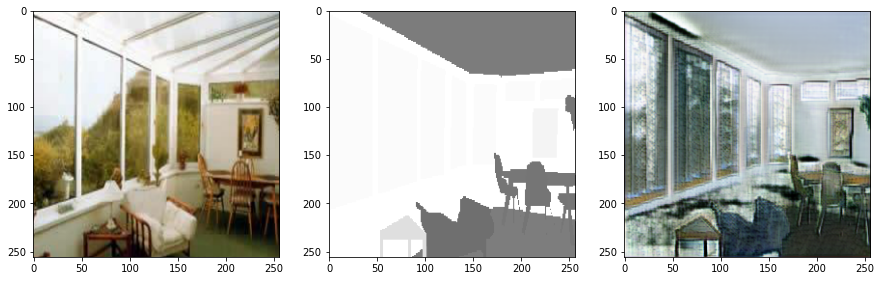

In [0]:
def show_results(epoch):
  # read images
  img_A = Image.open('/content/gdrive/My Drive/development/ai/3-gaugan/training/image_results/%s_real_image.png' % epoch)
  img_B = Image.open('/content/gdrive/My Drive/development/ai/3-gaugan/training/image_results/%s_input_label.png' % epoch)
  img_C = Image.open('/content/gdrive/My Drive/development/ai/3-gaugan/training/image_results/%s_synthesized_image.png' % epoch)

  # display images
  fig, ax = plt.subplots(1,3,figsize=(15,15))
  ax[0].imshow(img_A)
  ax[1].imshow(img_B)
  ax[2].imshow(img_C)

show_results('epoch005_iter118000')

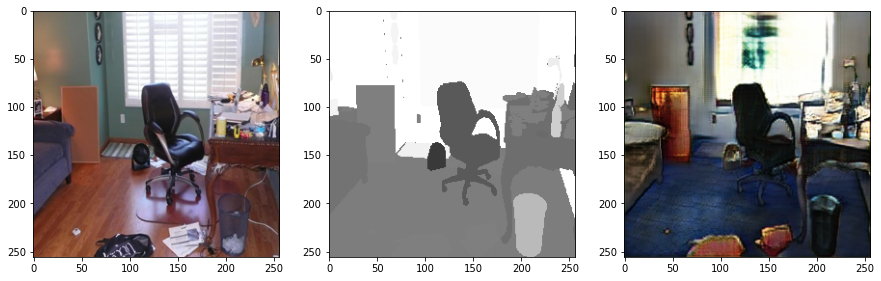

In [0]:
show_results('epoch009_iter184000')

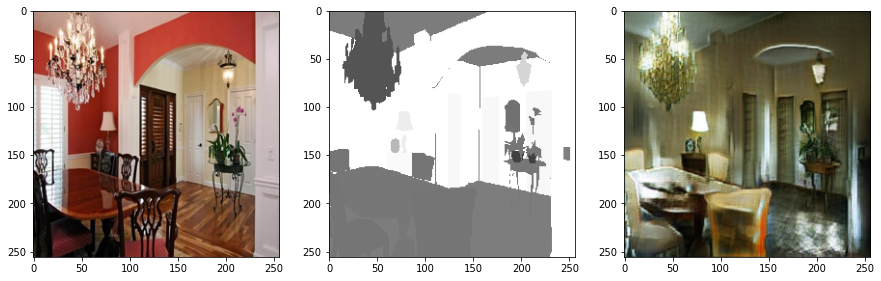

In [0]:
show_results('epoch009_iter185000')